In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

%matplotlib inline 

In [2]:
# import all pyphysio classes and methods
import pyphysio as ph

Please cite:
Bizzego et al. (2019) 'pyphysio: A physiological signal processing library for data science approaches in physiology', SoftwareX


In [3]:
# import data 
df_BVP = pd.read_csv('BVP_pp32.csv', header=None)

In [4]:
n_of_rows = df_BVP.count()
print(n_of_rows)

0    225973
dtype: int64


In [5]:
#count n of rows to get time of recording (s) 
n_of_rows = df_BVP.count()
print(n_of_rows)
#walk time in seconds 
walk_time_seconds = n_of_rows/64
print(walk_time_seconds)
#walk time in minutes
walk_time_minutes = walk_time_seconds/60
print(walk_time_minutes)

0    225973
dtype: int64
0    3530.828125
dtype: float64
0    58.847135
dtype: float64


In [6]:
#create BVP signal 
fsamp = 64  #64 Hz = 0.015625 s(p)
ecg = ph.EvenlySignal(values = df_BVP, sampling_freq = fsamp, signal_type = 'ecg')
tstart_df_BVP = 100 #s

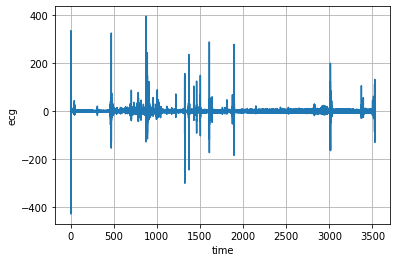

In [7]:
ecg.plot()

In [8]:
ibi = ph.BeatFromECG()(ecg)

In [9]:
ibi.get_duration() #

3530.828125

In [10]:
# create label
label = np.zeros(3530)
label[0:600] = 1
label[600:3530] = 2

label = ph.EvenlySignal(label, sampling_freq = 1, signal_type = 'label') 
#sampling_freq here is not intended as real sampfeq, only the distance between one point and the other (e.g. 10 = 10 units between 'begin' & 'end')

In [11]:
# (optional) IIR filtering : remove high frequency noise
#ecg = ph.IIRFilter(fp=45, fs = 50, ftype='ellip')(ecg)

In [12]:
# normalization : normalize data
ecg = ph.Normalize(norm_method='standard')(ecg)

In [13]:
# resampling : increase the sampling frequency by cubic interpolation
ecg = ecg.resample(fout=4096, kind='cubic')
fsamp = 4096

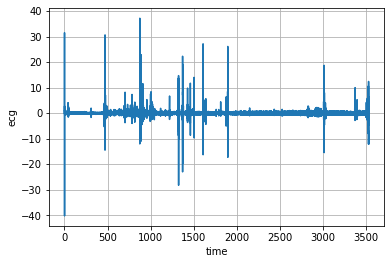

In [14]:
ecg.plot()

In [15]:
ibi = ph.BeatFromECG()(ecg)

In [16]:
ibi.get_duration()

3530.828125

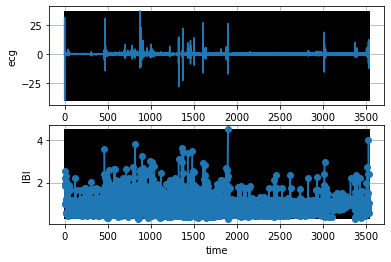

In [17]:
# check results so far
ax1 = plt.subplot(211)
ecg.plot()
plt.vlines(ibi.get_times(), np.min(ecg), np.max(ecg))

plt.subplot(212, sharex = ax1)
ibi.plot('o-')
plt.vlines(ibi.get_times(), np.min(ibi), np.max(ibi))
plt.show()

In [18]:
### physiological indicators 

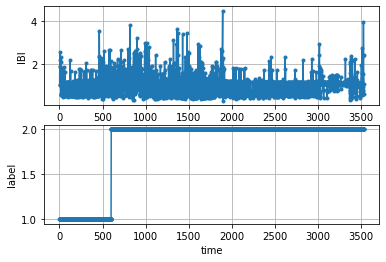

In [19]:
# check label
ax1 = plt.subplot(211)
ibi.plot('.-')

plt.subplot(212, sharex = ax1)
label.plot('.-')
plt.show()


In [20]:
# define a list of indicators we want to compute
hrv_indicators = [ph.Mean(name='RRmean'), ph.StDev(name='RRstd'), ph.RMSSD(name='rmsSD')]

In [21]:
#fixed length windowing
fixed_length = ph.FixedSegments(step = 60, width = 60, labels = label)

indicators, col_names = ph.fmap(fixed_length, hrv_indicators, ibi)

In [22]:
# extract column with the labels for each window
label_w = indicators[:, np.where(col_names == 'label')[0]]

# extract column with the RRmean values computed from each window
rrmean_w = indicators[:, np.where(col_names == 'RRmean')[0]]

rrmean_image1 = rrmean_w[np.where(label_w==1)[0]].ravel()
rrmean_image2 = rrmean_w[np.where(label_w==2)[0]].ravel()

{'whiskers': [<matplotlib.lines.Line2D at 0x1c23c9dc50>,
 'caps': [<matplotlib.lines.Line2D at 0x1c1a565450>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c23ca4a90>,
 'medians': [<matplotlib.lines.Line2D at 0x1c23cb4b90>,
 'fliers': [<matplotlib.lines.Line2D at 0x1c23caec90>,
 'means': []}

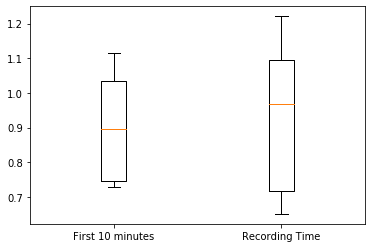

In [23]:
## create a box and whisker plot to compare the distibution of the RRmean indicator
plt.boxplot([rrmean_image1, rrmean_image2],
            labels=['First 10 minutes', 'Recording Time'])

In [24]:
HRV_FD = ph.preset_hrv_fd() #frequency domain HRV indicators
print(HRV_FD)

print(HRV_FD[0].get())

[IBI_VLF_Pow, IBI_LF_Pow, IBI_HF_Pow, IBI_Total_Pow]
{'freq_min': 1e-05, 'freq_max': 0.04, 'method': 'ar', 'interp_freq': 4, 'name': 'IBI_VLF_Pow'}


In [25]:
FD_HRV_ind, col_names = ph.fmap(fixed_length, ph.preset_hrv_fd(), ibi.resample(4))

In [26]:
import pandas as pd

# create a pandas dataframe
FD_HRV_pp32_df = pd.DataFrame(FD_HRV_ind, columns=col_names)

FD_HRV_pp32_df.head()

,begin,end,label,IBI_VLF_Pow,IBI_LF_Pow,IBI_HF_Pow,IBI_Total_Pow
0,1.232178,61.232178,1.0,610.396765,768.773945,753.009422,2951.977282
1,61.232178,121.232178,1.0,54.873000,198.742028,649.093554,1869.467610
2,121.232178,181.232178,1.0,153.647560,416.701069,865.858365,2252.425908
3,181.232178,241.232178,1.0,155.873526,429.212184,759.363954,2194.577849
4,241.232178,301.232178,1.0,134.014976,319.950947,743.351941,2011.599381


In [28]:
#save data 
FD_HRV_pp32_df.to_csv('FD_HRV_pp32.csv')